Ozuysal, Y. and S. A. Baccus (2012). "Linking the Computational Structure of Variance Adaptation to Biophysical Mechanisms." Neuron 73(5): 1002-1015.

# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
import pandas as pd
import os
import math


%matplotlib inline

In [2]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

# Set Parameter

In [3]:
m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

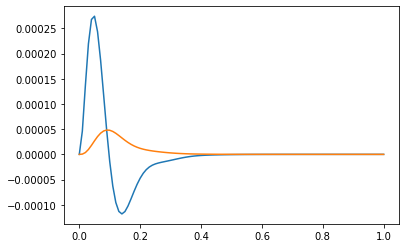

In [4]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

In [5]:
tot = 300
tAxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(tAxis))
mu, sigma = 0, 1
for i in range(len(tAxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

In [6]:
baseOutput = np.convolve(np.hstack((np.zeros(len(k_E)), x)), -k_E, 'full')[len(k_E):len(k_E)+len(x)]

(0.0, 5000.0)

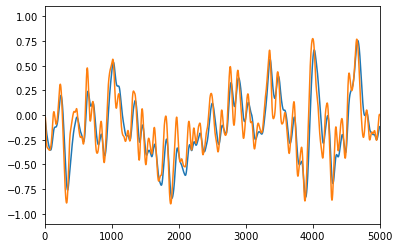

In [7]:
#Using notation of: J Neurophysiol 98: 1287–1296, 2007.
#Contrast Adaptation in a Nonadapting LGN Model
#Kate S. Gaudry and Pamela Reinagel

s = (x-min(x)) / (max(x)-min(x)) *2-1
g = (baseOutput-min(baseOutput))/(max(baseOutput)-min(baseOutput)) *2-1
# g = baseOutput/max(baseOutput)

plt.plot(-s)
plt.plot(g)
plt.xlim(0,5000)

# LNK

In [8]:
# four states kinetic model
# using the same notation as Ozuysal
# Eqn(11) in "Experimental Procedure" section

def kinetic(u,para,dt):
    ka  = para[0]
    kfr = para[1]
    kfi = para[2]
    ksr = para[3]
    ksi = para[4]
#   initial conditions for the four states
    p1 = 0.0
    p2 = 0
    p3 = 0.0
    p4 = 1.0

    p1r = []
    p2r = []
    p3r = []
    p4r = []
#
# 
#
    for i in range(len(u)):
        dp1 = (-u[i]*ka*p1  + kfr*p3)*dt
        dp2 =  (u[i]*ka*p1     - kfi*p2)*dt
        dp3 =  (kfi*p2 - (kfr+ksi)*p3 + u[i]*ksr*p4)*dt
        dp4 =  (ksi*p3 - u[i]*ksr*p4)*dt
    
        p1 = p1 + dp1
        p2 = p2 + dp2
        p3 = p3 + dp3
        p4 = p4 + dp4
    
        p1r.append(p1)
        p2r.append(p2)
        p3r.append(p3)
        p4r.append(p4)
        
# turn list into numpy arrays
    p1r = np.array(p1r)
    p2r = np.array(p2r)
    p3r = np.array(p3r)
    p4r = np.array(p4r)
    return (p1r,p2r,p3r,p4r)

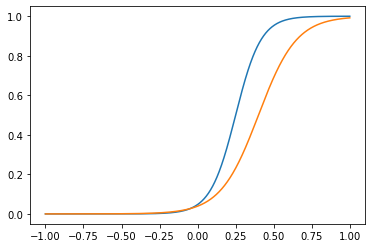

In [9]:
# Nonlinearity function
fastMidpoint = 0.25 # position of the mid point of the nonlinear function (tanh)
slowMidpoint = 0.4 # position of the mid point of the nonlinear function (tanh)
fastDR = 6 # dynamical range (?) of the nonlinear function (tanh)
slowDR = 4 # dynamical range (?) of the nonlinear function (tanh)


dummy = np.linspace(-1,1,1000)
plt.plot(dummy, (np.tanh((dummy-fastMidpoint)*fastDR)+1)/2)
plt.plot(dummy, (np.tanh((dummy-slowMidpoint)*slowDR)+1)/2)

In [10]:
# Fig 5
fastPara = [60, 6,   19, 0.02,  0.2]
# slowPara = [43, 6,    7, 0.01,  0.4]
slowPara = [39, 0.2,  25, 0.001,  0.6]

# DCCM

In [11]:
adaptationStep = int(50/dt)

mean = 10
contrast_list = np.array([0.5,1,1.5,2,3])/mean
fastOutput_list = [0]*len(contrast_list)
slowOutput_list = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    fastOutput_list[i] = -np.convolve(np.hstack((np.zeros(adaptationStep), x))*contrast_list[i]*mean+mean, k_E, 'full')[:adaptationStep+len(x)]
    slowOutput_list[i] =  np.convolve(np.hstack((np.zeros(adaptationStep), x))*contrast_list[i]*mean+mean, k_S, 'full')[:adaptationStep+len(x)]

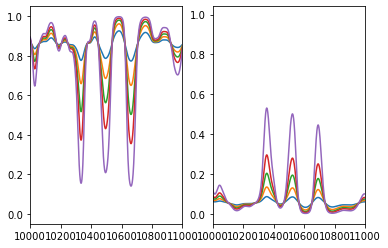

In [12]:
fastOutput_list = [(output-min(fastOutput_list[-1]))/(max(fastOutput_list[-1])-min(fastOutput_list[-1])) *2-1 for output in fastOutput_list] # rescaling
slowOutput_list = [(output-min(slowOutput_list[-1]))/(max(slowOutput_list[-1])-min(slowOutput_list[-1])) *2-1 for output in slowOutput_list]

fast_u = [(np.tanh((output-fastMidpoint)*fastDR)+1)/2 for output in fastOutput_list] 
slow_u = [(np.tanh((output-slowMidpoint)*slowDR)+1)/2 for output in slowOutput_list]
fig, ax = plt.subplots(1,2)
for i in range(len(contrast_list)):
    ax[0].plot(fast_u[i])
    ax[1].plot(slow_u[i])
for axi in ax:
    axi.set_xlim(5000+adaptationStep,6000+adaptationStep)

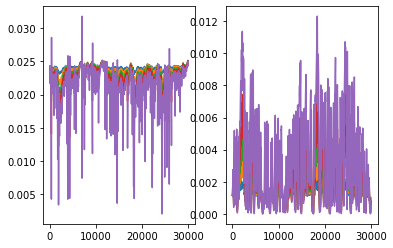

In [13]:
fast_A = [kinetic(u,fastPara,dt)[1][adaptationStep:] for u in fast_u]
slow_A = [kinetic(u,slowPara,dt)[1][adaptationStep:] for u in slow_u]
fig, ax = plt.subplots(1,2)
for i in range(len(contrast_list)):
    ax[0].plot(fast_A[i])
    ax[1].plot(slow_A[i])
# for axi in ax:
#     axi.set_xlim(5000,6000)
DCCM_A = fast_A+slow_A

### STA

In [14]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

DCCM_Xcorr = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    r = DCCM_A[i]
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    DCCM_Xcorr[i] = Xcorr.copy()

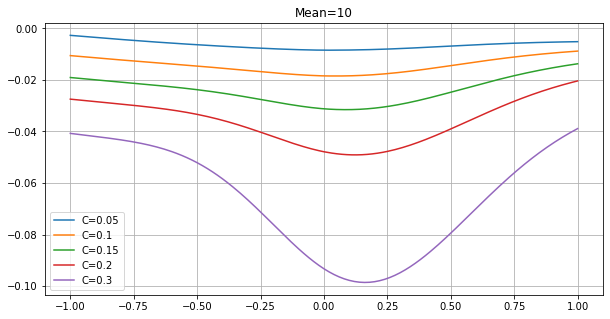

In [15]:
# plt.plot(timeaxis,baseXcorr, label= 'without gain', linestyle= 'dashed' )
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_Xcorr[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

# CCDM

In [16]:
adaptationStep = int(50/dt)

contrast = 0.2
mean_list = np.array([1,4,7,10,13])
fastOutput_list = [0]*len(mean_list)
slowOutput_list = [0]*len(mean_list)
for i in range(len(mean_list)):
    fastOutput_list[i] = -np.convolve(np.hstack((np.zeros(adaptationStep), x))*contrast*mean_list[i]+mean_list[i], k_E, 'full')[:adaptationStep+len(x)]
    slowOutput_list[i] =  np.convolve(np.hstack((np.zeros(adaptationStep), x))*contrast*mean_list[i]+mean_list[i], k_S, 'full')[:adaptationStep+len(x)]

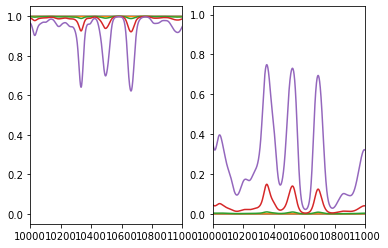

In [17]:
fastOutput_list = [(output-min(fastOutput_list[-1]))/(max(fastOutput_list[-1])-min(fastOutput_list[-1])) *2-1 for output in fastOutput_list] # rescaling
slowOutput_list = [(output-min(slowOutput_list[-1]))/(max(slowOutput_list[-1])-min(slowOutput_list[-1])) *2-1 for output in slowOutput_list]

fast_u = [(np.tanh((output-fastMidpoint)*fastDR)+1)/2 for output in fastOutput_list] 
slow_u = [(np.tanh((output-slowMidpoint)*slowDR)+1)/2 for output in slowOutput_list]
fig, ax = plt.subplots(1,2)
for i in range(len(mean_list)):
    ax[0].plot(fast_u[i])
    ax[1].plot(slow_u[i])
for axi in ax:
    axi.set_xlim(5000+adaptationStep,6000+adaptationStep)

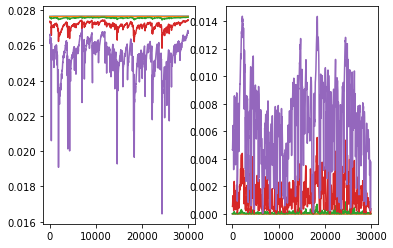

In [18]:
fast_A = [kinetic(u,fastPara,dt)[1][adaptationStep:] for u in fast_u]
slow_A = [kinetic(u,slowPara,dt)[1][adaptationStep:] for u in slow_u]
fig, ax = plt.subplots(1,2)
for i in range(len(mean_list)):
    ax[0].plot(fast_A[i])
    ax[1].plot(slow_A[i])
# for axi in ax:
#     axi.set_xlim(5000,6000)
CCDM_A = fast_A+slow_A

### STA

In [19]:
CCDM_Xcorr = [0]*len(mean_list)
for i in range(len(mean_list)):
    r = CCDM_A[i]
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    CCDM_Xcorr[i] = Xcorr.copy()

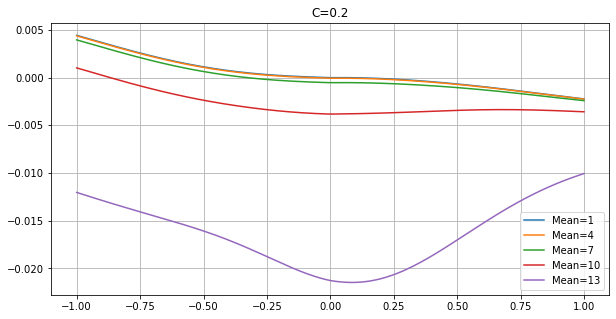

In [20]:
# plt.plot(timeaxis,baseXcorr, label= 'without gain', linestyle= 'dashed' )
for i in range(len(mean_list)): 
    plt.plot(timeaxis,CCDM_Xcorr[i], label = 'Mean='+str(round(mean_list[i])))
plt.legend()
plt.title('C='+str(contrast))
plt.grid('on')
plt.gcf().set_size_inches(10,5)